In [1]:
import sys, os
import numpy as np
import h5py
import math
import random
import neptune
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import tensorflow.keras.layers as nn

from tqdm import tqdm
from PIL import Image
from functools import partial
from inspect import isfunction
from tensorflow import keras, einsum
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Layer, Input, MaxPooling2D, Conv2D, Conv2DTranspose, Flatten, Dropout, Dense, BatchNormalization, Activation, Reshape
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow_probability.python.distributions import kl_divergence
from einops import rearrange
from einops.layers.tensorflow import Rearrange
from DataMakerPlus import *

2023-10-07 22:08:56.946636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-07 22:08:57.500035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
%%capture
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2023-10-07 22:08:58.151955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-07 22:08:58.170156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-07 22:08:58.170345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
channels = 5
BATCH_SIZE = 8

TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_training_z_less_than_2.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_testing_z_less_than_2.hdf5'

gen_args = {
    'image_key': 'image',
    'numerical_keys': None,
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'shuffle': False}
train_gen = HDF5DataGenerator(TRAIN_PATH, mode = 'train', **gen_args)
test_gen = HDF5DataGenerator(TEST_PATH, mode = 'train', **gen_args)
print(train_gen[0][0].shape) # a batch of images
print(train_gen[0][1].shape) # a batch of corresponding redshifts

(8, 5, 64, 64)
(8,)


In [4]:
batch_count = 0
def next_batch():
    global batch_count
    x_train = np.asarray(np.transpose(train_gen[batch_count][0], (0, 2, 3, 1)))
    y_train = train_gen[batch_count][1]
    batch_count = batch_count + 1
    if batch_count == len(train_gen) - 1:
        batch_count = 0
    return x_train, y_train

In [5]:
timesteps = 1000
max_noise = 0.02

# create a fixed beta schedule
beta = np.linspace(max_noise / timesteps, max_noise, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[ : -1]), axis = 0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1 - alpha_bar)

# this function will help us set the RNG key for Numpy
def set_key(key):
    np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size = x_0.shape)
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    set_key(key)
    return tf.random.uniform(shape = [num], minval = 0, maxval = timesteps, dtype = tf.int32)

In [6]:
# Let us visualize the output image at a few timestamps
sample = next_batch()[0][0]

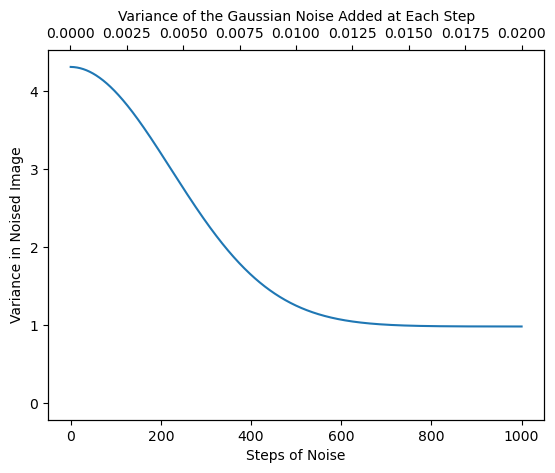

In [7]:
y_arr = np.array([])
for index, i in enumerate(range(timesteps)):
    noisy_im, noise = forward_noise(0, np.expand_dims(sample, 0), np.array([i, ]))
    y_arr = np.append(y_arr, np.var(noisy_im.flatten()))

x_arr = np.linspace(0, timesteps, timesteps)

fig, ax1 = plt.subplots()
ax1.plot(x_arr, y_arr)
ax1.set_xlabel("Steps of Noise")
ax1.set_ylabel("Variance in Noised Image")

ax2 = ax1.twiny()
ax2.plot(beta, 0 * np.ones(timesteps), alpha = 0) # Create a dummy plot
ax2.set_xlabel("Variance of the Gaussian Noise Added at Each Step")
plt.show()

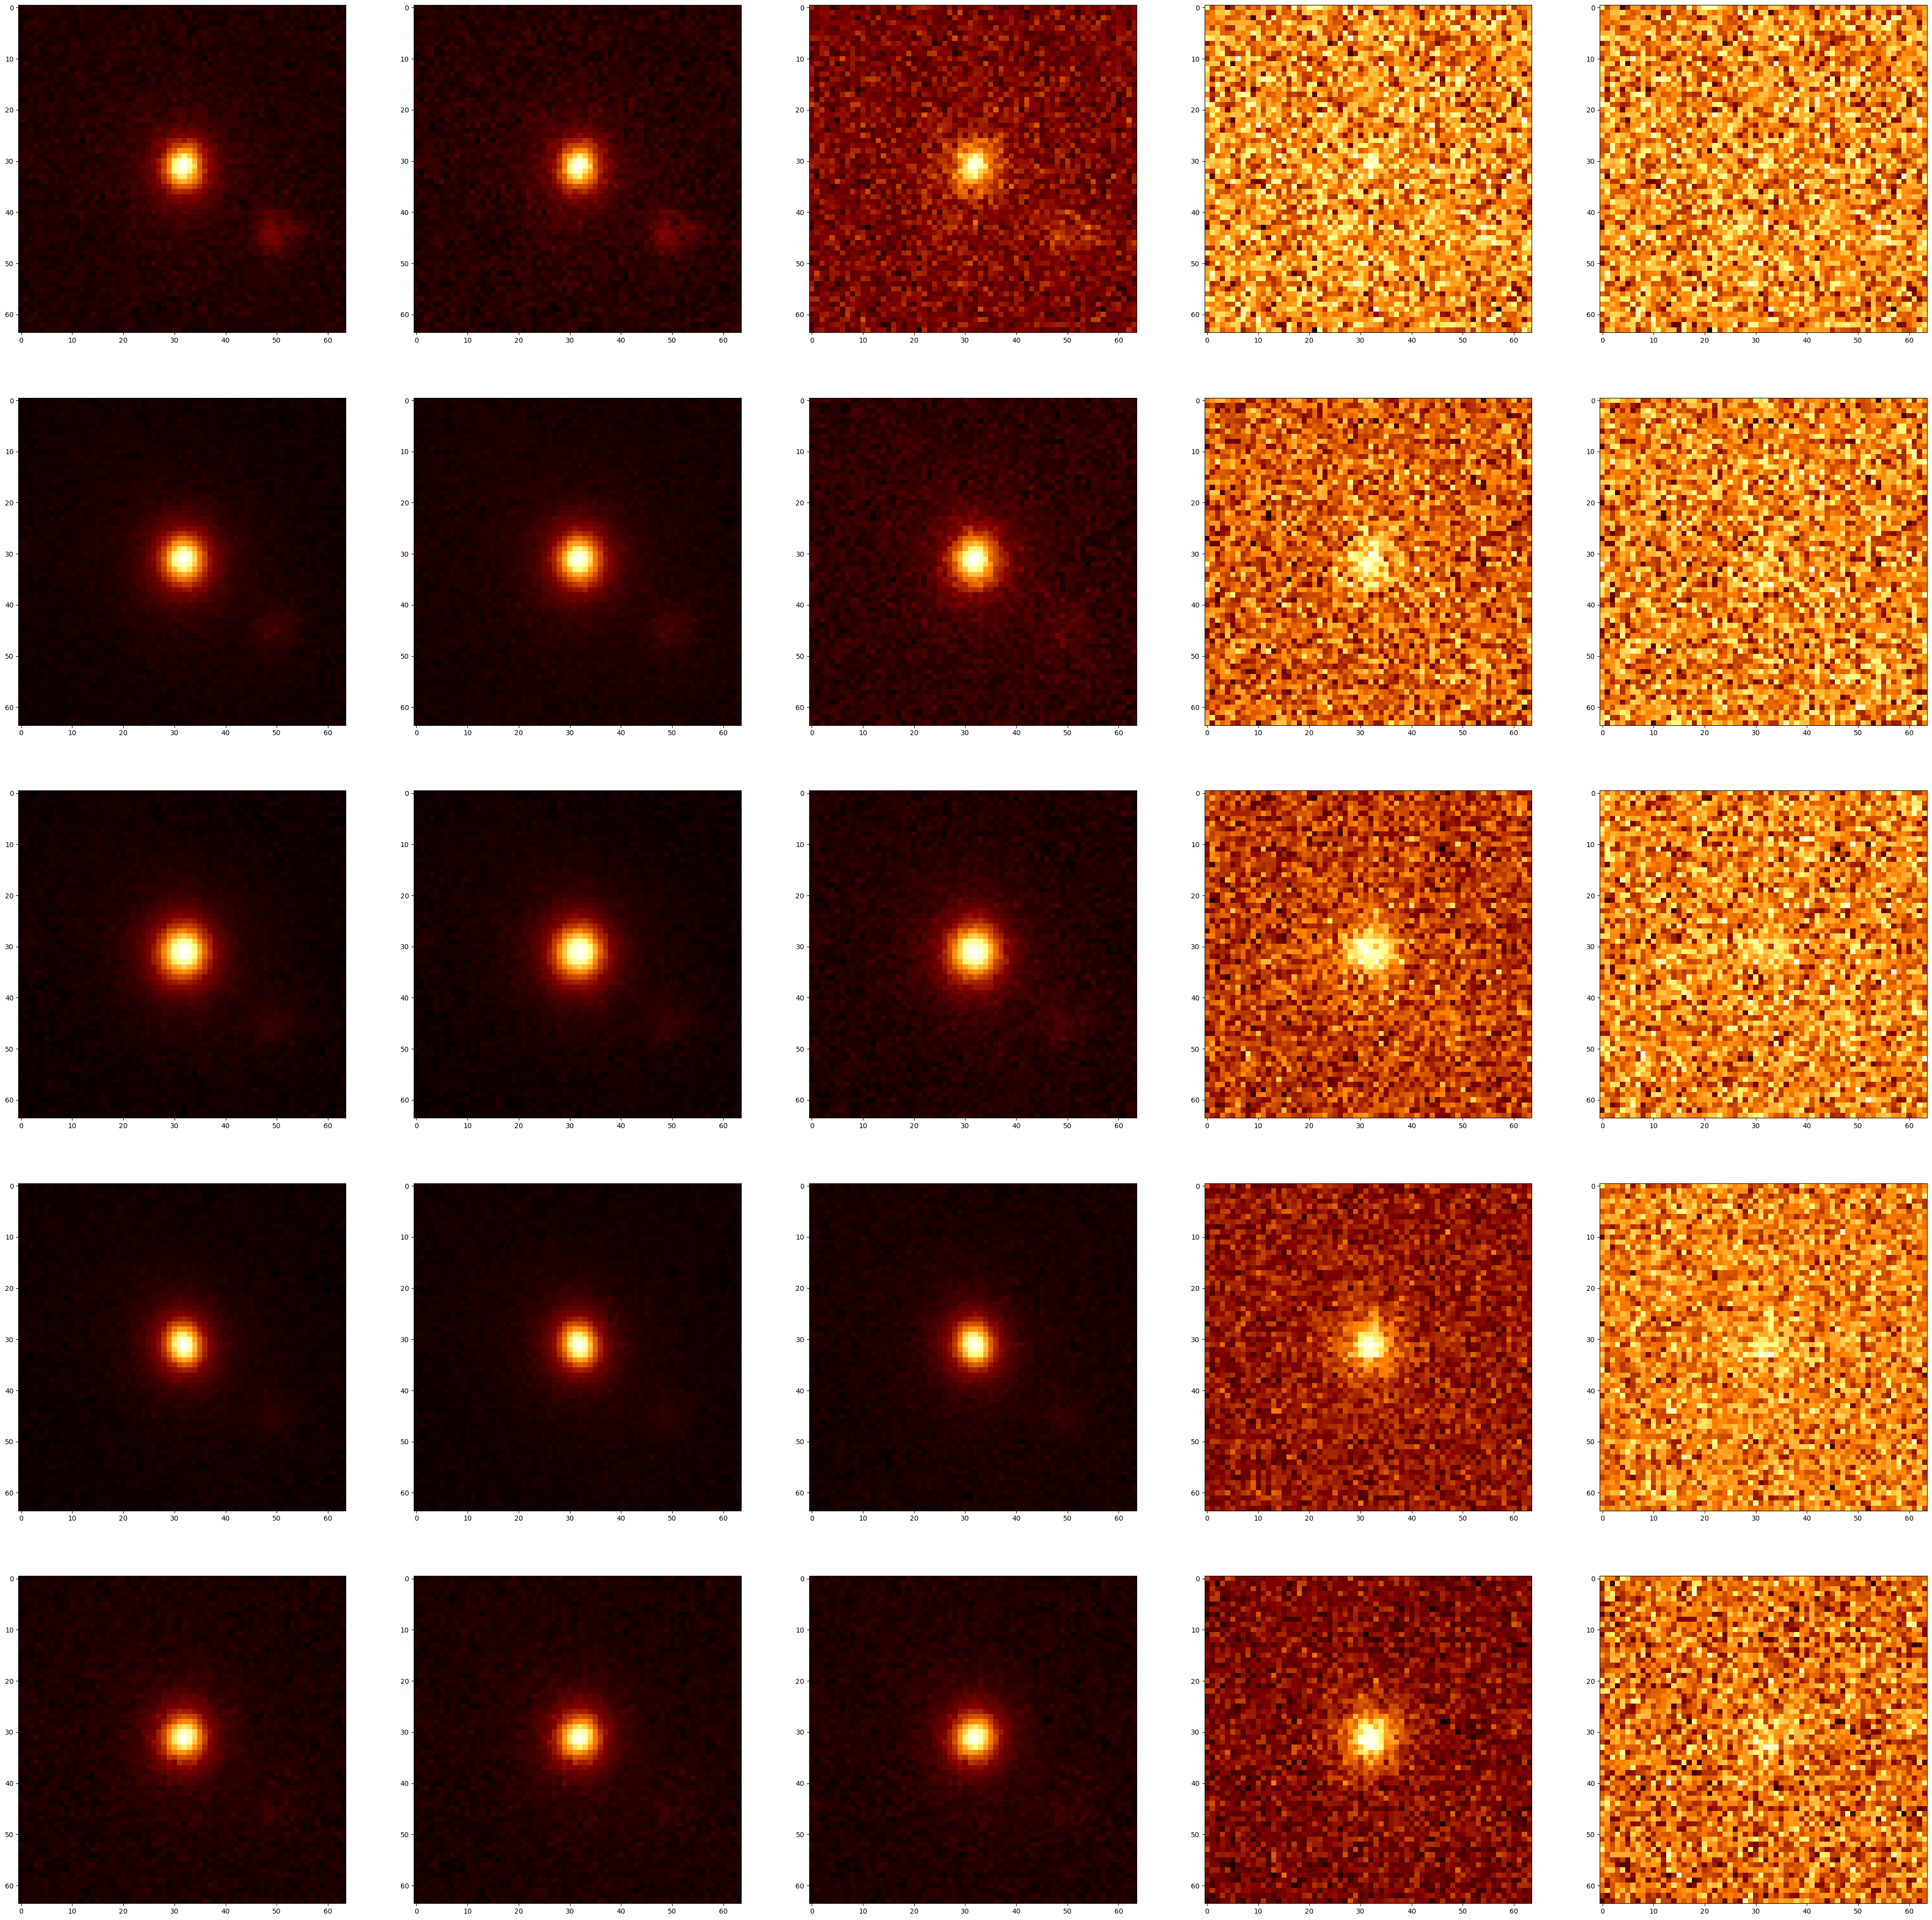

In [8]:
fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (50, 50))

j = 0

for index, i in enumerate([0, 20, 100, 500, 750]):
    noisy_im, noise = forward_noise(0, np.expand_dims(sample, 0), np.array([i, ]))
    axes[0][j].imshow(noisy_im[0][:, :, 0], cmap = 'afmhot')
    axes[1][j].imshow(noisy_im[0][:, :, 1], cmap = 'afmhot')
    axes[2][j].imshow(noisy_im[0][:, :, 2], cmap = 'afmhot')
    axes[3][j].imshow(noisy_im[0][:, :, 3], cmap = 'afmhot')
    axes[4][j].imshow(noisy_im[0][:, :, 4], cmap = 'afmhot')
    j += 1
    

plt.show()

In [9]:
print("Data Initialization Complete!")

Data Initialization Complete!


In [10]:
# helpers functions
def exists(x):
    return x is not None

# We will use this to convert timestamps to time encodings
class SinusoidalPosEmb(Layer):
    def __init__(self, dim, max_positions = 10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training = True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype = tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis = -1)

        return emb
        
# small helper modules
class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training = True):
        return tf.identity(x)


class Residual(Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x, training = True):
        return self.fn(x, training = training) + x

class LayerNorm(Layer):
    def __init__(self, dim, eps = 1e-5, **kwargs):
        super(LayerNorm, self).__init__(**kwargs)
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, 1, 1, dim]))
        self.b = tf.Variable(tf.zeros([1, 1, 1, dim]))

    def call(self, x, training = True):
        var = tf.math.reduce_variance(x, axis = -1, keepdims = True)
        mean = tf.reduce_mean(x, axis = -1, keepdims = True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x

class PreNorm(Layer):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def call(self, x, training = True):
        x = self.norm(x)
        return self.fn(x)

class SiLU(Layer):
    def __init__(self):
        super(SiLU, self).__init__()

    def call(self, x, training = True):
        return tf.nn.silu(x)

def gelu(x, approximate = False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class GELU(Layer):
    def __init__(self, approximate = False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training = True):
        return gelu(x, self.approximate)

class MLP(Layer):
    def __init__(self, hidden_dim, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.net = Sequential([
            Rearrange('... -> ... 1'),  # expand_dims(axis=-1)
            nn.Dense(units = hidden_dim),
            GELU(),
            LayerNorm(hidden_dim),
            nn.Dense(units = hidden_dim),
            GELU(),
            LayerNorm(hidden_dim),
            nn.Dense(units = hidden_dim),
        ])

    def call(self, x, training = True):
        return self.net(x, training = training)


class ValueConditioning(Layer):  # Modify class name
    def __init__(self, res, num_channels = 5):
        super().__init__()
        self.block = Sequential([
            Dense(200),
            Dropout(0.2), 
            Dense(res * res * num_channels),
            SiLU(),
            Reshape((res, res, num_channels))
        ])

        self.block.compile()

    def call(self, x):  # Modify method signature
        return self.block(x)

In [11]:
# building block modules
class Block(Layer):
    def __init__(self, dim, groups = 8):
        super(Block, self).__init__()
        self.proj = nn.Conv2D(dim, kernel_size = 3, strides = 1, padding = 'same')
        self.norm = tfa.layers.GroupNormalization(groups, epsilon = 1e-05)
        self.act = SiLU()


    def call(self, x, gamma_beta = None, training = True):
        x = self.proj(x)
        x = self.norm(x, training = training)

        if exists(gamma_beta):
            gamma, beta = gamma_beta
            x = x * (gamma + 1) + beta

        x = self.act(x)
        return x

class ResnetBlock(Layer):
    def __init__(self, dim, dim_out, time_emb_dim = None, groups = 8):
        super(ResnetBlock, self).__init__()

        self.mlp = Sequential([
            SiLU(),
            nn.Dense(units = dim_out * 2)
        ]) if exists(time_emb_dim) else None

        self.block1 = Block(dim_out, groups = groups)
        self.block2 = Block(dim_out, groups = groups)
        self.res_conv = nn.Conv2D(filters = dim_out, kernel_size = 1, strides = 1) if dim != dim_out else Identity()

    def call(self, x, time_emb = None, training = True):
        gamma_beta = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b 1 1 c')
            gamma_beta = tf.split(time_emb, num_or_size_splits = 2, axis = -1)

        h = self.block1(x, gamma_beta = gamma_beta, training = training)
        h = self.block2(h, training = training)

        return h + self.res_conv(x)

class LinearAttention(Layer):
    def __init__(self, dim, heads = 4, dim_head = 16):
        super(LinearAttention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.to_qkv = Conv2D(self.hidden_dim * 3, 1, 1, use_bias = False)

        self.to_out = Sequential([
            Conv2D(filters = dim, kernel_size = 1, strides = 1),
            LayerNorm(dim)
        ])

    def call(self, x, training = True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x) # convolves the layer input into multiples of 3 numbers of filters, so they can be split to query, key, and value
        qkv = tf.split(qkv, num_or_size_splits = 3, axis = -1)
        
        q = rearrange(qkv[0], 'b x y (h c) -> b h c (x y)', h = self.heads) # batch size, heads, channels, x, y arrangement for the images
        k = rearrange(qkv[1], 'b x y (h c) -> b h c (x y)', h = self.heads)
        v = rearrange(qkv[2], 'b x y (h c) -> b h c (x y)', h = self.heads)

        q = tf.nn.softmax(q, axis = -2) # Query normalized according to each head
        k = tf.nn.softmax(k, axis = -1) # Key normalized according to each (x, y) coordinate

        q = q * self.scale
        context = einsum('b h d n, b h e n -> b h d e', k, v)

        out = einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b x y (h c)', h = self.heads, x = h, y = w)
        out = self.to_out(out, training = training)

        return out

In [12]:
class Unet_conditional(Model):
    def __init__(self,
                 dim = 64,
                 dim_mults = (1, 2, 4, 8),
                 channels = 5,
                 in_res = 64
                 ):
        super(Unet_conditional, self).__init__()

        # determine dimensions
        self.channels = channels
        self.in_res = in_res

        init_dim = 42
        self.init_conv = nn.Conv2D(filters = init_dim, kernel_size = 7, strides = 1, padding = 'same')

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        # time embeddings
        time_dim = dim * 4
        self.time_mlp = Sequential([SinusoidalPosEmb(dim), Dense(units = time_dim), GELU(), Dense(units = time_dim)], name = "time embeddings")

        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)

        now_res = in_res

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                ValueConditioning(now_res),
                ResnetBlock(dim_in + 1, dim_out, time_emb_dim = time_dim),
                ResnetBlock(dim_out, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Conv2D(dim_out, 4, 2, padding = 'same') if not is_last else Identity()
            ])

            now_res //= 2 if not is_last else 1

        mid_dim = dims[-1]
        self.mid_conditioning = ValueConditioning(now_res)
        self.mid_block1 = ResnetBlock(mid_dim + 1, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, LinearAttention(mid_dim)))
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1 : ])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                ValueConditioning(now_res),
                ResnetBlock((dim_out * 2) + 1, dim_in, time_emb_dim = time_dim),
                ResnetBlock(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Conv2DTranspose(dim_in, 4, 2, padding = 'same') if not is_last else Identity()
            ])

            now_res *= 2 if not is_last else 1

        self.out_dim = channels

        self.final_conv = Sequential([
            ResnetBlock(dim * 2, dim),
            nn.Conv2D(filters = self.out_dim, kernel_size = 1, strides = 1)
        ], name = "output")
        
    # def summary(self):
        # x1 = Input(shape = (1, 64, 64, 5))
        # x2 = generate_timestamp(0, 1)
        # x3 = Input(shape = (1))
        # model = Model(inputs = [x1, x2, x3], outputs = self.call(x1, x2, x3))
        # return model.summary()
    
    def call(self, x, time = None, condition_vector = None, training = True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)

        # class_vector = self.class_embeddings(class_vector)
        
        h = []

        for conditioning, block1, block2, attn, downsample in self.downs:
            cv = conditioning(condition_vector)
            x = tf.concat([x, cv], axis = -1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)
        
        cv = self.mid_conditioning(condition_vector)
        x = tf.concat([x, cv], axis = -1)
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for conditioning, block1, block2, attn, upsample in self.ups:
            cv = conditioning(condition_vector)
            x = tf.concat([x, cv], axis = -1)
            x = tf.concat([x, h.pop()], axis = -1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis = -1)
        x = self.final_conv(x)
        return x

In [13]:
unet = Unet_conditional(in_res = 64, channels = 5)

test_images = np.ones([1, 64, 64, channels])
test_timestamps = generate_timestamp(0, 1)
test_condition = np.array([[1.0]])
k = unet(test_images, test_timestamps, test_condition)

opt = keras.optimizers.Adam(learning_rate = 1e-4)

2023-10-07 22:09:03.663721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-07 22:09:04.203567: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-07 22:09:04.377800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [14]:
unet.summary()

Model: "unet_conditional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  10332     
                                                                 
 time embeddings (Sequential  (1, 256)                 82432     
 )                                                               
                                                                 
 value_conditioning (ValueCo  multiple                 4116880   
 nditioning)                                                     
                                                                 
 resnet_block (ResnetBlock)  multiple                  100288    
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 107008    
 )                                                               
                                                  

In [15]:
def loss_fn(real, generated):
    loss = tf.math.reduce_mean((real - generated) ** 2)
    return loss

In [16]:
plot_model(unet, to_file='unet_model.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
print("Network Initialization Complete!")

Network Initialization Complete!


In [18]:
def train_step(batch, condition):
    noise, noise_step = np.random.randint(0, 100000, size = (2,))
    timestep_values = generate_timestamp(noise_step, batch.shape[0])

    noised_image, noise = forward_noise(noise, batch, tf.cast(timestep_values, tf.int32))
    with tf.GradientTape() as tape:
        prediction = unet(noised_image, timestep_values, condition)
        
        loss_value = loss_fn(noise, prediction)
    
    gradients = tape.gradient(loss_value, unet.trainable_variables)
    opt.apply_gradients(zip(gradients, unet.trainable_variables))

    return loss_value

epochs = 10

for e in range(0, epochs):
    opt.learning_rate = 2e-4
    bar = tf.keras.utils.Progbar(len(train_gen))
    losses = []
    for i in range(0, len(train_gen)):
        batch, condition = next_batch()
        loss = train_step(batch, condition)
        losses.append(loss)
        bar.update(i, values=[("loss", loss)])  

    avg = np.mean(losses)
    
    if e > 8:
        opt.learning_rate = 1e-5
        
    print(f"Average loss for epoch {e}/{epochs}: {avg}")

2023-10-07 22:09:09.686260: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x8a94bb70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-07 22:09:09.686283: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-07 22:09:09.689783: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-07 22:09:09.744407: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-07 22:09:09.789970: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24313/24314 [============================>.] - ETA: 0s - loss: 0.0973Average loss for epoch 0/1: 0.09729577600955963


In [ ]:
unet.save_weights('/data3/Billy/unnormalized_weights_full_quadratic_1.csv')

In [ ]:
unet.load_weights('/data3/Billy/unnormalized_weights_full_quadratic_1.csv')

In [ ]:
stop here

In [ ]:
def save_gif(img_list, path = "", interval = 200):
    # Transform images from [-1,1] to [0, 255]
    imgs = []
    for im in img_list:
        im = np.array(im)
        max = np.amax(np.nan_to_num(img_list))
        min = np.amin(np.nan_to_num(img_list))
        im = (im - min) / (max - min) * 255
        im = np.clip(im, 0, 255).astype(np.int32)
        im = Image.fromarray(im)
        imgs.append(im)
    
    imgs = iter(imgs)

    # Extract first image from iterator
    img = next(imgs)

    # Append the other images and save as GIF
    img.save(fp = path, format='GIF', append_images = imgs,
             save_all = True, duration = interval, loop = 0)

In [ ]:
def ddpm(x_t, pred_noise, t):
    alpha_t = np.take(alpha, t)
    alpha_t_bar = np.take(alpha_bar, t)

    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
    mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

    var = np.take(beta, t)
    z = np.random.normal(size=x_t.shape)

    return mean + (var ** .5) * z

In [ ]:
for k in range(0, 5):
    z = k / 2 + 0.1
    x = tf.random.normal((1, 64, 64, 5))

    img_list_g = []
    img_list_r = []
    img_list_i = []
    img_list_z = []
    img_list_y = []
    img_list_g.append(np.squeeze(x, 0)[: , : , 0])
    img_list_r.append(np.squeeze(x, 0)[: , : , 1])
    img_list_i.append(np.squeeze(x, 0)[: , : , 2])
    img_list_z.append(np.squeeze(x, 0)[: , : , 3])
    img_list_y.append(np.squeeze(x, 0)[: , : , 4])
    
    for i in tqdm(range(timesteps - 1)):
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, np.array([z]), t)
        x = ddpm(x, pred_noise, t)
        img_list_g.append(np.squeeze(x, 0)[: , : , 0])
        img_list_r.append(np.squeeze(x, 0)[: , : , 1])
        img_list_i.append(np.squeeze(x, 0)[: , : , 2])
        img_list_z.append(np.squeeze(x, 0)[: , : , 3])
        img_list_y.append(np.squeeze(x, 0)[: , : , 4])
            

    save_gif(img_list_g + ([img_list_g[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_g.gif", interval = 20)
    save_gif(img_list_r + ([img_list_r[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_r.gif", interval = 20)
    save_gif(img_list_i + ([img_list_i[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_i.gif", interval = 20)
    save_gif(img_list_z + ([img_list_z[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_z.gif", interval = 20)
    save_gif(img_list_y + ([img_list_y[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_y.gif", interval = 20)

In [ ]:
z = random.uniform(0, 4)

x = tf.random.normal((1, 64, 64, 5))

for i in tqdm(range(timesteps - 1)):
    
    t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
    pred_noise = unet(x, np.array([z]), t)
    x = ddpm(x, pred_noise, t)
    
image_g = np.squeeze(x, 0)[: , : , 0][:-1, :-1]
image_r = np.squeeze(x, 0)[: , : , 1][:-1, :-1]
image_i = np.squeeze(x, 0)[: , : , 2][:-1, :-1]
image_z = np.squeeze(x, 0)[: , : , 3][:-1, :-1]
image_y = np.squeeze(x, 0)[: , : , 4][:-1, :-1]

five_band_image = np.array([image_g, image_r, image_i, image_z, image_y])
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])

hf = h5py.File('/data3/Diffusion/64x64_diffusion_generated_1.hdf5', 'a')
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 64, 64))
hf.create_dataset('specz_redshift', data = [z], chunks = True, maxshape = (None, ))

for i in tqdm(range(1999)):
    
    z = random.uniform(0, 4)
    
    x = tf.random.normal((1, 64, 64, 5))
    
    for i in range(timesteps - 1):
        
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, np.array([z]), t)
        x = ddpm(x, pred_noise, t)
    
    image_g = np.squeeze(x, 0)[: , : , 0][:-1, :-1]
    image_r = np.squeeze(x, 0)[: , : , 1][:-1, :-1]
    image_i = np.squeeze(x, 0)[: , : , 2][:-1, :-1]
    image_z = np.squeeze(x, 0)[: , : , 3][:-1, :-1]
    image_y = np.squeeze(x, 0)[: , : , 4][:-1, :-1]
    
    five_band_image = np.array([image_g, image_r, image_i, image_z, image_y])
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
    
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image

hf.close()

In [ ]:
print("Data Generation Complete!")

In [ ]:
# END